In [1]:
!pip install tfds-nightly -q

In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import scipy
import gc

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.2.0


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [256, 256]
EPOCHS = 25

In [83]:
BATCH_SIZE = 25
IMAGE_SIZE = [350, 350]

In [7]:
_, info = tfds.load('dtd', split='train', with_info=True)

In [87]:
CLASS_NAMES = info.features["label"].names
NUM_CLASSES = info.features["label"].num_classes

print("Class names: ")
print(CLASS_NAMES)
print("Number of classes: " + str(NUM_CLASSES))

Class names: 
['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 'cracked', 'crosshatched', 'crystalline', 'dotted', 'fibrous', 'flecked', 'freckled', 'frilly', 'gauzy', 'grid', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike', 'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated', 'pitted', 'pleated', 'polka-dotted', 'porous', 'potholed', 'scaly', 'smeared', 'spiralled', 'sprinkled', 'stained', 'stratified', 'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven', 'wrinkled', 'zigzagged']
Number of classes: 47


In [92]:
train_ds, val_ds, test_ds = tfds.load('dtd', split=['train', 'validation', 'test'], shuffle_files=True)

In [93]:
train_ds = train_ds.map(lambda items: (items["image"], tf.one_hot(items["label"], NUM_CLASSES)))

val_ds = val_ds.map(lambda items: (items["image"], tf.one_hot(items["label"], NUM_CLASSES)))

In [94]:
for image, label in train_ds.take(1):
    print(label)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(47,), dtype=float32)


In [95]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 350, 350)
  return image,label

In [96]:
train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

In [97]:
image_batch, label_batch = next(iter(train_ds))

In [98]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[np.argmax(label_batch[n])])
        plt.axis("off")

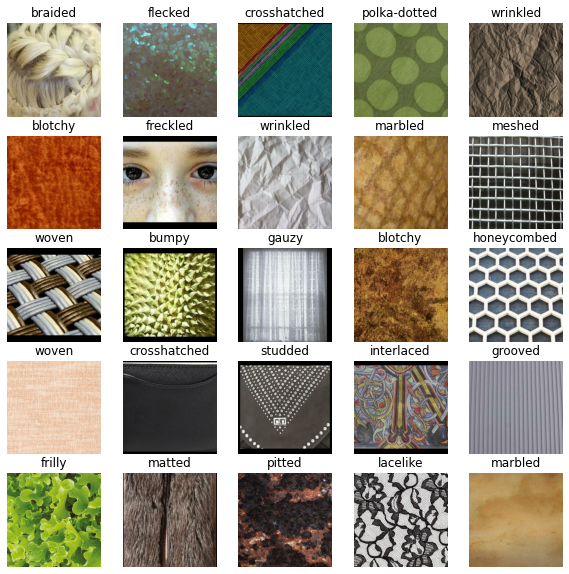

In [99]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [100]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [101]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [111]:
def build_model(): 
    base_model = tf.keras.applications.VGG16(input_shape=(*IMAGE_SIZE, 3),
                                             include_top=False,
                                             weights='imagenet')
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics='accuracy')
    
    return model

In [112]:
model = build_model()

58892288/58889256 [==============================] - 0s 0us/step


In [113]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("texture_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [114]:
history = model.fit(
    train_ds, epochs=20,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/20
76/76 [==============================] - 26s 337ms/step - loss: 3.0954 - accuracy: 0.2271 - val_loss: 2.4688 - val_accuracy: 0.3617 - lr: 0.0100
Epoch 2/20
76/76 [==============================] - 25s 333ms/step - loss: 2.0568 - accuracy: 0.4410 - val_loss: 2.2066 - val_accuracy: 0.4128 - lr: 0.0089
Epoch 3/20
76/76 [==============================] - 25s 330ms/step - loss: 1.7350 - accuracy: 0.5293 - val_loss: 2.0909 - val_accuracy: 0.4346 - lr: 0.0079
Epoch 4/20
76/76 [==============================] - 25s 330ms/step - loss: 1.5378 - accuracy: 0.5910 - val_loss: 2.0257 - val_accuracy: 0.4479 - lr: 0.0071
Epoch 5/20
76/76 [==============================] - 25s 331ms/step - loss: 1.3983 - accuracy: 0.6293 - val_loss: 1.9834 - val_accuracy: 0.4585 - lr: 0.0063
Epoch 6/20
76/76 [==============================] - 25s 330ms/step - loss: 1.2937 - accuracy: 0.6681 - val_loss: 1.9541 - val_accuracy: 0.4691 - lr: 0.0056
Epoch 7/20
76/76 [==============================] - 25s 331ms/st

In [117]:
test_ds = test_ds.map(lambda items: (items["image"], tf.one_hot(items["label"], NUM_CLASSES)))

test_ds = (
    test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

In [118]:
model.evaluate(test_ds)

76/76 [==============================] - 13s 165ms/step - loss: 1.7849 - accuracy: 0.5207


[1.784920573234558, 0.5207446813583374]